In [1]:
import save_utils
from config import DATA_FOLDER, FIGURES_FOLDER

import xarray as xr
import numpy as np
from scipy.stats import bayes_mvs

import itertools as itr
import os


/home/csquires/projects/orderdag-bounds/venv/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/csquires/projects/orderdag-bounds/venv/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [3]:
def get_dags_folder(p, s):
    return os.path.join(DATA_FOLDER, 's=%s/p=%s' % (s, p))

## PARAMETERS OF GRAPHS

In [4]:
node_sizes = [3, 5] + list(range(10, 111, 20))
node_size_labels = ['', ''] + list(range(10, 111, 20))
ndags = 2000
sparsities = [.1, .2, .5, .7]
num_interventions = [0, 1, 2]
excluded = [[(.7, 130), (.7, 150)]]

CONFIDENCE = .95

In [5]:
colors = sns.color_palette()
linestyles = ['-', '--', 'dotted']

num_interventions_linestyles = list(zip(num_interventions, linestyles))
sparsity_colors = list(zip(sparsities, colors))

sparsity_labels = [
    mpatches.Patch(color=color, label=r'$\rho$ = %s' % s)
    for s, color in sparsity_colors
]
intervention_labels = [
    mlines.Line2D([0], [0], linestyle=linestyle, color='k', label='r = %s' % k)
    for k, linestyle in num_interventions_linestyles
]
all_handles = list(itr.chain.from_iterable(itr.zip_longest(sparsity_labels, intervention_labels, fillvalue=mlines.Line2D([0], [0], alpha=0))) )

### Create data arrays for number of unoriented edges and MEC sizes

In [6]:
num_unoriented = xr.DataArray(
    np.zeros([len(sparsities), len(node_sizes), ndags, len(num_interventions)]),
    dims=['sparsity', 'nnodes', 'dag', 'num_interventions'], 
    coords={
        'sparsity': sparsities, 
        'nnodes': node_sizes, 
        'dag': list(range(ndags)),
        'num_interventions': num_interventions
    }
)
mec_sizes = num_unoriented.copy()
num_ivs_to_orient = xr.DataArray(
    np.zeros([len(sparsities), len(node_sizes), ndags]),
    dims=['sparsity', 'nnodes', 'dag'],
    coords={
        'sparsity': sparsities,
        'nnodes': node_sizes,
        'dag': list(range(ndags))
    }
)

In [7]:
for s, p, k in itr.product(sparsities, node_sizes, num_interventions):
    if (s, p) not in excluded:
        fn = os.path.join(get_dags_folder(p, s), 'k=%s_num_unoriented.txt' % k)
        num_unoriented.loc[dict(sparsity=s, nnodes=p, num_interventions=k)] = save_utils.load_list(fn) if os.path.exists(fn) else None

        fn = os.path.join(get_dags_folder(p, s), 'k=%s_mec_sizes.txt' % k)
        mec_sizes.loc[dict(sparsity=s, nnodes=p, num_interventions=k)] = save_utils.load_list(fn) if os.path.exists(fn) else None
for s, p in itr.product(sparsities, node_sizes):
    if (s, p) not in excluded:
        fn = os.path.join(get_dags_folder(p, s), 'num_ivs_to_orient.txt')
        num_ivs_to_orient.loc[dict(sparsity=s, nnodes=p)] = save_utils.load_list(fn) if os.path.exists(fn) else None

In [8]:
log2_mec_sizes = np.log2(mec_sizes)
is_updag = (num_unoriented==0).astype(int)

## Plot average number of unoriented edges

/home/csquires/projects/orderdag-bounds/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/csquires/projects/orderdag-bounds/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


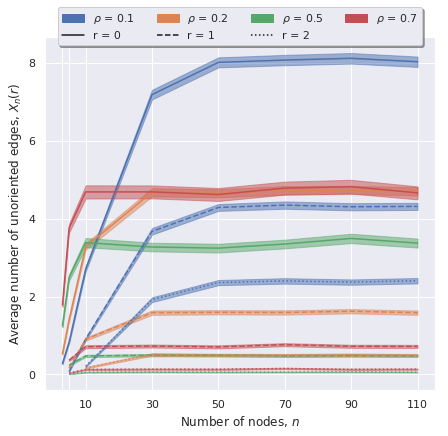

In [9]:
plt.figure(figsize=(7, 6.5))
for (k, linestyle), (s, color) in itr.product(num_interventions_linestyles, sparsity_colors):
    mvs_list = [
        bayes_mvs(num_unoriented.sel(sparsity=s, num_interventions=k, nnodes=n), alpha=CONFIDENCE) 
        for n in node_sizes
    ]
    avs = [mvs[0] for mvs in mvs_list]
    av_stats = [av.statistic for av in avs]
    av_mins, av_maxes = zip(*[av.minmax for av in avs])
    plt.plot(
        node_sizes, 
        av_stats, 
        linestyle=linestyle, 
        color=color,
        label='s=%s' % s
    )
    plt.fill_between(
        node_sizes,
        av_mins,
        av_maxes,
        color=color,
        alpha=.5
    )
plt.xticks(node_sizes, node_size_labels)
plt.xlabel('Number of nodes, $n$')
plt.ylabel('Average number of unoriented edges, $X_n(r)$')
plt.legend(handles=all_handles, ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.1), shadow=True);
plt.savefig(os.path.join(FIGURES_FOLDER, 'unoriented_edges.png'))

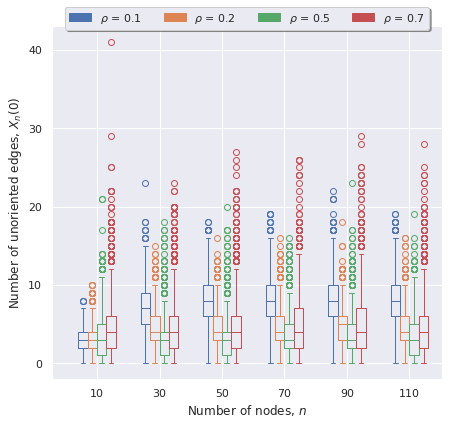

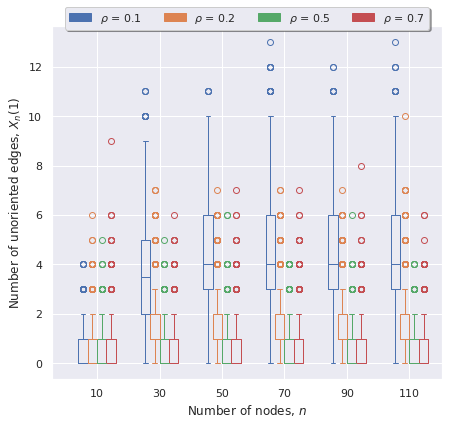

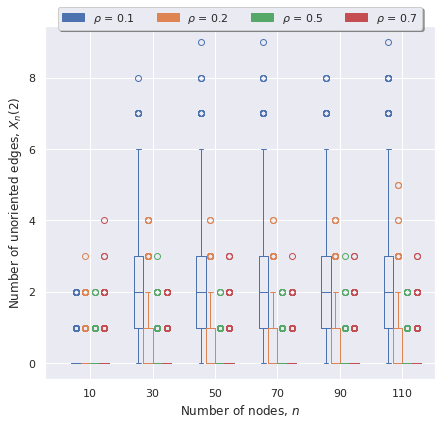

In [10]:
for k in num_interventions:
    plt.figure(figsize=(7, 6.5))

    sel_node_sizes = np.array(node_sizes[2:])

    for i, (s, c) in enumerate(sparsity_colors):
        xs = [num_unoriented.sel(sparsity=s, num_interventions=k, nnodes=n).values for n in sel_node_sizes]
        b = plt.boxplot(
            xs, 
            positions=sel_node_sizes+3*i, 
            widths=3, 
        );
        for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(b[item], color=c)
        plt.setp(b["fliers"], markeredgecolor=c)
        plt.xticks(sel_node_sizes+4.5, sel_node_sizes);
    plt.xlim([0, 125])
    plt.xlabel('Number of nodes, $n$')
    plt.ylabel('Number of unoriented edges, $X_n(%s)$' % k)
    plt.legend(handles=sparsity_labels, ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.07), shadow=True);
    plt.savefig(os.path.join(FIGURES_FOLDER, 'unoriented_edges_box_r=%s.png' % k))

## Plot P(isUPDAG)

/home/csquires/projects/orderdag-bounds/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/csquires/projects/orderdag-bounds/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


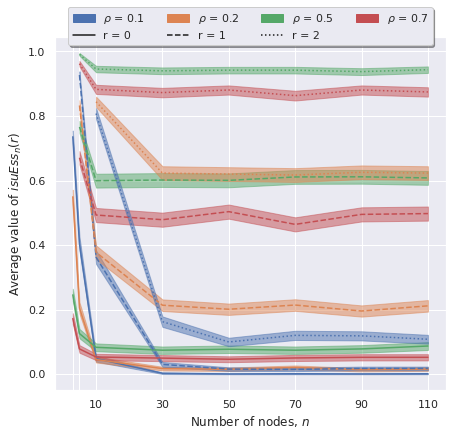

In [11]:
plt.figure(figsize=(7, 6.5))
for (k, linestyle), (s, color) in itr.product(num_interventions_linestyles, sparsity_colors):
    mvs_list = [
        bayes_mvs(is_updag.sel(sparsity=s, num_interventions=k, nnodes=n), alpha=CONFIDENCE) 
        for n in node_sizes
    ]
    avs = [mvs[0] for mvs in mvs_list]
    av_stats = [av.statistic for av in avs]
    av_mins, av_maxes = zip(*[av.minmax for av in avs])
    plt.plot(
        node_sizes, 
        av_stats, 
        linestyle=linestyle, 
        color=color,
        label='s=%s' % s
    )
    plt.fill_between(
        node_sizes,
        av_mins,
        av_maxes,
        color=color,
        alpha=.5
    )
plt.xticks(node_sizes, node_size_labels)
plt.xlabel('Number of nodes, $n$')
plt.ylabel('Average value of $isuEss_n(r)$')
plt.legend(handles=all_handles, ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.1), shadow=True);
plt.savefig(os.path.join(FIGURES_FOLDER, 'percent_updags.png'))

## Plot Average MEC size

/home/csquires/projects/orderdag-bounds/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/csquires/projects/orderdag-bounds/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


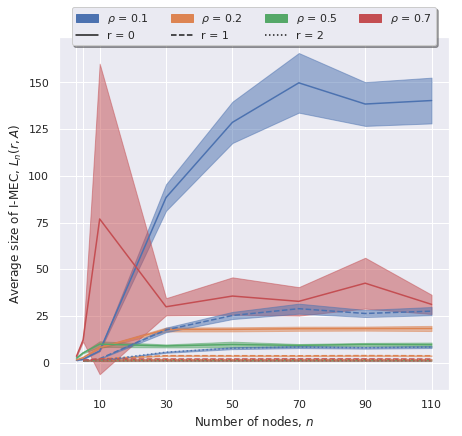

In [12]:
plt.figure(figsize=(7, 6.5))
for (k, linestyle), (s, color) in itr.product(num_interventions_linestyles, sparsity_colors):
    mvs_list = [
        bayes_mvs(mec_sizes.sel(sparsity=s, num_interventions=k, nnodes=n), alpha=CONFIDENCE) 
        for n in node_sizes
    ]
    avs = [mvs[0] for mvs in mvs_list]
    av_stats = [av.statistic for av in avs]
    av_mins, av_maxes = zip(*[av.minmax for av in avs])
    plt.plot(
        node_sizes, 
        av_stats, 
        color=color,
        linestyle=linestyle,
        label='s=%s' % s
    )
    plt.fill_between(
        node_sizes,
        av_mins,
        av_maxes,
        color=color,
        alpha=.5
    )
plt.xticks(node_sizes, node_size_labels)
plt.xlabel('Number of nodes, $n$')
plt.ylabel('Average size of I-MEC, $L_n(r, A)$')
plt.legend(handles=all_handles, ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.1), shadow=True);
plt.savefig(os.path.join(FIGURES_FOLDER, 'mec_sizes.png'))

## Plot Average log MEC size

/home/csquires/projects/orderdag-bounds/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/csquires/projects/orderdag-bounds/venv/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


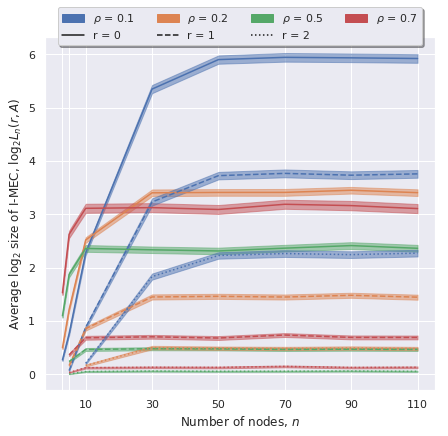

In [13]:
plt.figure(figsize=(7, 6.5))
for (k, linestyle), (s, color) in itr.product(num_interventions_linestyles, sparsity_colors):
    mvs_list = [
        bayes_mvs(log2_mec_sizes.sel(sparsity=s, num_interventions=k, nnodes=n), alpha=CONFIDENCE) 
        for n in node_sizes
    ]
    avs = [mvs[0] for mvs in mvs_list]
    av_stats = [av.statistic for av in avs]
    av_mins, av_maxes = zip(*[av.minmax for av in avs])
    plt.plot(
        node_sizes, 
        av_stats, 
        color=color,
        linestyle=linestyle,
        label='s=%s' % s
    )
    plt.fill_between(
        node_sizes,
        av_mins,
        av_maxes,
        color=color,
        alpha=.5
    )
plt.xticks(node_sizes, node_size_labels)
plt.xlabel('Number of nodes, $n$')
plt.ylabel('Average $\log_2$ size of I-MEC, $\log_2 L_n(r, A)$')
plt.legend(handles=all_handles, ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.1), shadow=True);
plt.savefig(os.path.join(FIGURES_FOLDER, 'log_mec_sizes.png'))

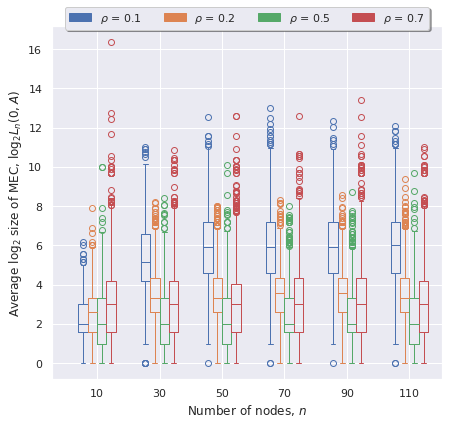

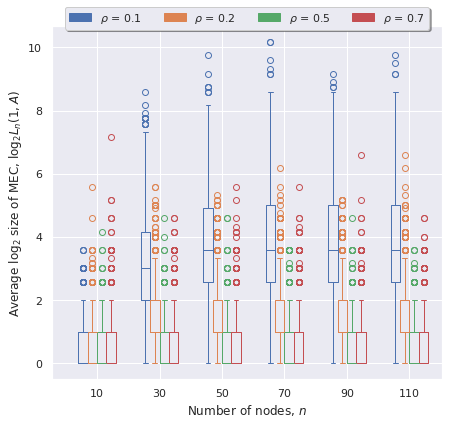

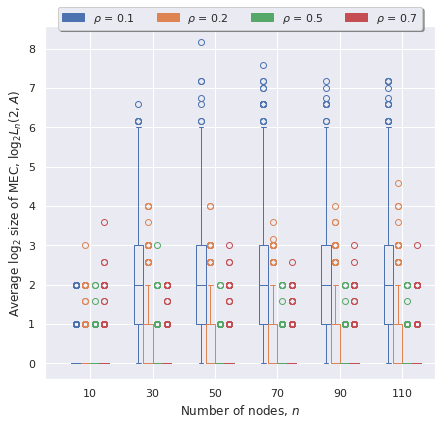

In [14]:
for k in num_interventions:
    plt.figure(figsize=(7, 6.5))

    sel_node_sizes = np.array(node_sizes[2:])

    for i, (s, c) in enumerate(sparsity_colors):
        xs = [log2_mec_sizes.sel(sparsity=s, num_interventions=k, nnodes=n).values for n in sel_node_sizes]
        b = plt.boxplot(
            xs, 
            positions=sel_node_sizes+3*i, 
            widths=3, 
        );
        for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(b[item], color=c)
        plt.setp(b["fliers"], markeredgecolor=c)
        plt.xticks(sel_node_sizes+4.5, sel_node_sizes);
    plt.xlim([0, 125])
    plt.xlabel('Number of nodes, $n$')
    plt.ylabel('Average $\log_2$ size of MEC, $\log_2 L_n(%s, A)$' % k)
    plt.legend(handles=sparsity_labels, ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.07), shadow=True);
    plt.savefig(os.path.join(FIGURES_FOLDER, 'log_mec_sizes_box_r=%s.png' % k))

## Plot number interventions needed to fully orient

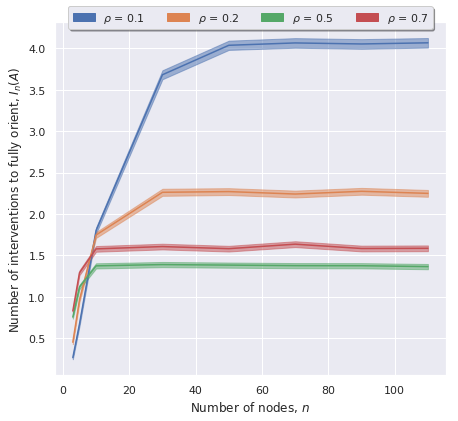

In [15]:
plt.figure(figsize=(7, 6.5))
for s, color in sparsity_colors:
    mvs_list = [
        bayes_mvs(num_ivs_to_orient.sel(sparsity=s, nnodes=n), alpha=CONFIDENCE) 
        for n in node_sizes
    ]
    avs = [mvs[0] for mvs in mvs_list]
    av_stats = [av.statistic for av in avs]
    av_mins, av_maxes = zip(*[av.minmax for av in avs])
    plt.plot(
        node_sizes,
        av_stats,
        color=color
    )
    plt.fill_between(
        node_sizes,
        av_mins,
        av_maxes,
        color=color,
        alpha=.5
    )
    
plt.xlabel('Number of nodes, $n$')
plt.ylabel('Number of interventions to fully orient, $I_n(A)$')
plt.legend(handles=sparsity_labels, ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.06), shadow=True);
plt.savefig(os.path.join(FIGURES_FOLDER, 'fully_orienting_interventions.png'))

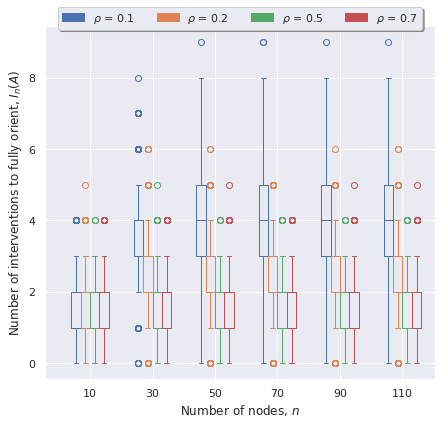

In [16]:
plt.figure(figsize=(7, 6.5))

sel_node_sizes = np.array(node_sizes[2:])

for i, (s, c) in enumerate(sparsity_colors):
    xs = [num_ivs_to_orient.sel(sparsity=s, nnodes=n).values for n in sel_node_sizes]
    b = plt.boxplot(
        xs, 
        positions=sel_node_sizes+3*i, 
        widths=3, 
    );
    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(b[item], color=c)
    plt.setp(b["fliers"], markeredgecolor=c)
    plt.xticks(sel_node_sizes+4.5, sel_node_sizes);
plt.xlim([0, 125])
plt.xlabel('Number of nodes, $n$')
plt.ylabel('Number of interventions to fully orient, $I_n(A)$')
plt.legend(handles=sparsity_labels, ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.07), shadow=True);
plt.savefig(os.path.join(FIGURES_FOLDER, 'fully_orienting_interventions_box.png'))

In [19]:
!zip figures.zip figures/*

  adding: figures/fully_orienting_interventions.png (deflated 5%)
  adding: figures/fully_orienting_interventions_box.png (deflated 12%)
  adding: figures/log_mec_sizes.png (deflated 2%)
  adding: figures/log_mec_sizes_box_r=0.png (deflated 5%)
  adding: figures/log_mec_sizes_box_r=1.png (deflated 7%)
  adding: figures/log_mec_sizes_box_r=2.png (deflated 10%)
  adding: figures/mec_sizes.png (deflated 2%)
  adding: figures/percent_updags.png (deflated 2%)
  adding: figures/unoriented_edges.png (deflated 2%)
  adding: figures/unoriented_edges_box_r=0.png (deflated 8%)
  adding: figures/unoriented_edges_box_r=1.png (deflated 10%)
  adding: figures/unoriented_edges_box_r=2.png (deflated 12%)
